In [1]:
import numpy as np
import pandas as pd
#import aplpy

from scipy.optimize import curve_fit

import astropy.io.fits as fits
from astropy.visualization import simple_norm
from astropy.visualization import SqrtStretch
from astropy.stats import sigma_clip, sigma_clipped_stats, mad_std
from astropy import wcs
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.visualization.mpl_normalize import ImageNormalize

from astroquery.sdss import SDSS
from astroquery.vizier import Vizier

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#from matplotlib.patches import Rectangle

#import ccdproc
#from ccdproc import CCDData, Combiner
#from ccdproc import median_filter

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.datasets import make_100gaussians_image

In [41]:
def _match(refradecs, bands, survey, ra_center, dec_center,v):
    '''
    catalog matching
    
    refradecs   [str]: radec lists
    band          [str]: photometry band list
    survey        [str]: survey name in the catalog. (ex.'II/349') 
    ra_center    [str]: ex. '20:12:40.0'
    dec_center [str]: ex.'-02:08:44'
    v                [str]: catalog filter (ex.Vizier(column_filters={'q_mode':'+', 'class':'6', 'Q':'3'}))
    
    return: 1. cat_sdss_cut,
               2. idxs
               3. sep_constraints
        
    '''
    
    
    magee = [[] for _ in range(len(bands))]
    
    for i in range(len(bands)):
        magee[i] = bands[i] + 'mag'
        
    v.ROW_LIMIT=-1
    
    cat_sdss = v.query_region(coord.SkyCoord(ra=ra_center, dec=dec_center, unit=(u.hour,u.deg), frame='icrs'),\
                                radius=40*u.arcmin, catalog=[survey]) 

    mask=(cat_sdss[0][magee[0]]>0) 
        
    cat_sdss_cut = cat_sdss[0][mask]
    
    coo_m3 = SkyCoord(ra=refradecs.T[0]*u.degree, dec=refradecs.T[1]*u.degree)

    #panstarsかそれ以外かでカラム名変わるから分岐いる
    coo_sdss = SkyCoord(ra=cat_sdss_cut['RAJ2000'], dec=cat_sdss_cut['DEJ2000'])
    #coo_sdss = SkyCoord(ra=cat_sdss_cut['RAJ2000'], dec=cat_sdss_cut['DEJ2000']) # for PS1

    idx, d2d, d3d = coo_m3.match_to_catalog_sky(coo_sdss)

    max_sep = 0.9*u.arcsec
    sep_constraint = d2d < max_sep
    coo_m3_matches = coo_m3[sep_constraint]
    coo_sdss_matches = coo_sdss[idx[sep_constraint]]
    
    return  cat_sdss_cut, idx, sep_constraint



In [42]:
hdu0 = fits.open('./ztf_20180420451319_000439_zr_c12_o_q4_sciimg_ra303.1674_dec-2.1442_asec1200.fits.gz')
#peaks of each pixels
data = hdu0[0].data
#data = data[400:800, 400:800]
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))  

(218.71135, 218.43492, 7.3309455)


In [ ]:
hdu0.

In [43]:
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
print(type(sources.to_pandas()))

<class 'pandas.core.frame.DataFrame'>


In [44]:
fwhm_r = 2.5
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=fwhm_r*2)
annulus_aperture = CircularAnnulus(positions, r_in=fwhm_r*2+2, r_out=4*fwhm_r+2)
annulus_masks = annulus_aperture.to_mask(method='center')
norm = ImageNormalize(stretch=SqrtStretch())

bkg_median = []
for mask in annulus_masks:
    noise = np.sqrt(data)
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, apertures,error=noise)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output

(550.0, 650.0)

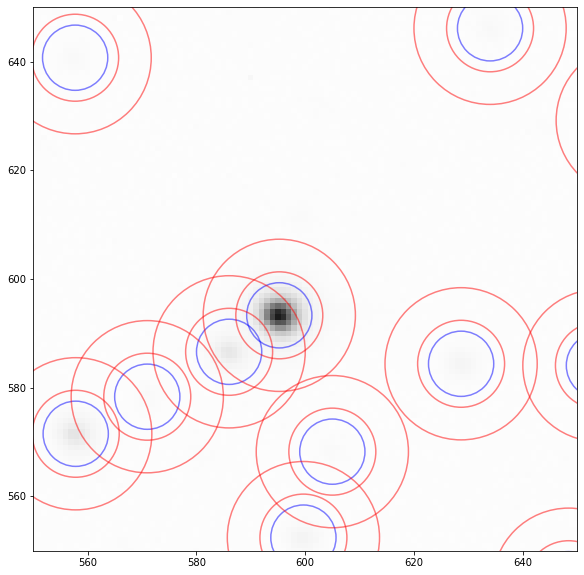

In [76]:
plt.figure(figsize=(10,10))
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)
plt.xlim(550,650)
plt.ylim(550,650)

In [46]:
phots = phot.to_pandas()

expt = hdu0[0].header['EXPOSURE']
phots['mag'] = -2.5*np.log10(phots['aperture_sum']/expt)
phots['magerr'] = 2.5* phots['aperture_sum_err']/(phots['aperture_sum']/expt) / np.log(10)
phots[:3]

,id,xcenter,ycenter,aperture_sum,aperture_sum_err,annulus_median,aper_bkg,aper_sum_bkgsub,mag,magerr
0,1,552.991127,0.464602,19836.710485,140.842858,210.385376,23794.025457,-3957.314972,-7.050871,0.231265
1,2,773.588918,0.925344,18329.466853,135.386362,208.612267,23593.491504,-5264.024651,-6.965071,0.240586
2,3,756.305444,3.803791,31007.976113,176.090818,213.101440,24101.205110,6906.771003,-7.535880,0.184973


In [75]:
hdu0[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1186                                                  
NAXIS2  =                 1186                                                  
BUNIT   = 'Data Value'                                                          
ORIGIN  = 'Zwicky Transient Facility' / Data origin                             
OBSERVER= 'ZTF Robotic Observing Software' / Observer                           
ROBOSOFT= '0.87  April 17, 2018' / Robotic software version                     
FITSSOFT= '0.87  April 17, 2018' / FITS software version                        
INSTRUME= 'ZTF/MOSAIC'         / Instrument name                                
DETECTOR= '        '           / Detector controller                            
DETSOFT = '        '        

In [47]:
xys = phots[['xcenter', 'ycenter']].to_numpy()
w = wcs.WCS(hdu0[0].header)
radec = w.wcs_pix2world(xys, 0)

In [48]:
survey = 'II/349' #The Pan-STARRS release 1 (PS1) Survey - DR1 (Chambers+, 2016) 
ra_center='20:12:40.0'
dec_center='-02:08:44'
v=Vizier(column_filters={'q_mode':'+', 'class':'6', 'Q':'3'})
cat_sdss_cut, idxs, sep_constraints = _match(radec,'r',survey,ra_center,dec_center,v)

In [72]:
print('all:',len(phots))
print('true:',len(np.where(sep_constraints)[0]))

all: 1352
true: 1329


In [59]:
def _mag_calc( mag, idxs_f, sep_constraints_f, cat_sdss_cut_mag):
    #zero_mag = []
    #target_mag = []
    #mag_name = band + 'mag'
    #sigmas = []
    
    #sep_constraints_f[i][target_id[i]]=False
    zero_mag = np.median(cat_sdss_cut_mag[idxs_f[sep_constraints_f]] - mag[sep_constraints_f])
    #target_mag.append(zero_mag[i] + mag[i][target[i][0]])
    
    return zero_mag

In [65]:
zeromags = _mag_calc(phots['mag'], idxs, sep_constraints, cat_sdss_cut['rmag'])

TypeError: unsupported operand type(s) for -: 'float' and 'SingleBlockManager'

In [64]:
for i,j in zip(range(len(phots)),range(len(phots))):
    x1 = phots['xcenter'][i]
    y1 = phots['ycenter'][i]
    
    x2 = phots['xcenter'][j]
    y2 = phots['ycenter'][j]
    
    
    p1 = np.array([x1,y1]).T
    p2 = np.array([x2,y2]).T
    
    vec = p1 - p2
    dist = np.linalg.norm(vec, axis=1)
    phot['distance'] = dist

array([[5.52991127e+02, 4.64602424e-01],
       [7.73588918e+02, 9.25344437e-01],
       [7.56305444e+02, 3.80379135e+00],
       ...,
       [6.95746646e+02, 1.18378071e+03],
       [1.08130903e+03, 1.18398566e+03],
       [5.19746923e+02, 1.18469113e+03]])